In [1]:
import ee
import geemap
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import pickle
import time
import glob
import seaborn as sns
from pathlib import Path

# # Get the current notebook's directory
# notebook_dir = Path().absolute()

# # Go up one level to the project root
# project_root = notebook_dir.parent

# # Add the project root to sys.path
# sys.path.append(str(project_root))

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# print(module_path)

# Now try to import
from gee_helpers.gee_helpers import initialize_gee
initialize_gee()

Google Earth Engine has initialized successfully!


## Run LEAF-toolbox on selected abandoned well polygons 

Asset used for this section was created in GEE script **create_sampler_asset**

## Other notes:

 - SR results will be used with these functions.
 - LAI results will be obtained with functions to be imported.

### LC08 reflectance

This is with the filtered asset (steps in script random_polygons) with 1000 random 
selected abandoned wells.


In [2]:
# Read the LC08 files into one dataframe
pickle_directory = 'data_out'
pickle_files = glob.glob(f"{pickle_directory}/time_series_LC08_batch_*.pkl")
dataframes = []
for pkl_file in pickle_files:
    with open(pkl_file, 'rb') as file:
        df = pickle.load(file)
        dataframes.append(df)

lc08 = pd.concat(dataframes, ignore_index = True)

# # Export results
# with open('time_series_harmonized.pkl', 'wb') as file:
#     pickle.dump(combined_df, file)

In [3]:
# Check the columns
print(list(lc08.columns))

# Check # observatios per site
grouped_df = lc08.groupby("site").size()
print("Number of observatios per site: ")
print(grouped_df)
max(grouped_df)
min(grouped_df)

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'date', 'longitude', 'latitude', 'cosVZA', 'cosSZA', 'cosRAA', 'partition', 'site']
Number of observatios per site: 
site
282       1891
443       1915
575       1962
607       1937
678       1445
          ... 
336784     858
337611    2050
337661    1113
344681     908
346867    1889
Length: 1000, dtype: int64


60

## Time series trends

### Canopy cover

In [4]:
# Obtain NDVI to calculate canopy cover
def calculate_ndvi(df, red_band, nir_band):
    """
    Calculate NDVI and add it as a new column to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the reflectance values.
    red_band (str): The column name for the red band reflectance values.
    nir_band (str): The column name for the near-infrared band reflectance values.
    
    Returns:
    pd.DataFrame: The DataFrame with an additional 'NDVI' column.
    """
    df['ndvi'] = (df[nir_band] - df[red_band]) / (df[nir_band] + df[red_band])
    return df
    
lc08 = calculate_ndvi(lc08, 'SR_B4', 'SR_B5')
lc08.head()

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,SR_QA_AEROSOL,ST_B10,ST_ATRAN,...,QA_RADSAT,date,longitude,latitude,cosVZA,cosSZA,cosRAA,partition,site,ndvi
0,-0.000515,0.014555,0.040653,0.044255,0.158270,0.090840,0.060837,194.0,36644.0,9409.0,...,0.0,1617906520576,-112.889180,54.291849,0.9997,0.6617,0.7643,1,172358,0.562968
1,0.037463,0.055887,0.081545,0.102197,0.203728,0.181590,0.126755,224.0,37290.0,9408.0,...,0.0,1617906520576,-112.888719,54.291856,0.9997,0.6617,0.7645,1,172358,0.331879
2,0.045492,0.070792,0.109980,0.143888,0.241210,0.250780,0.179912,224.0,37439.0,9407.0,...,0.0,1617906520576,-112.888259,54.291863,0.9997,0.6617,0.7648,1,172358,0.252722
3,0.027205,0.054347,0.098815,0.134317,0.243520,0.258068,0.179032,192.0,37229.0,9406.0,...,0.0,1617906520576,-112.887798,54.291871,0.9997,0.6617,0.7650,15,172358,0.289020
4,0.007405,0.022585,0.054375,0.059957,0.178730,0.118450,0.077943,224.0,36618.0,9409.0,...,0.0,1617906520576,-112.889192,54.292118,0.9997,0.6617,0.7642,1,172358,0.497607


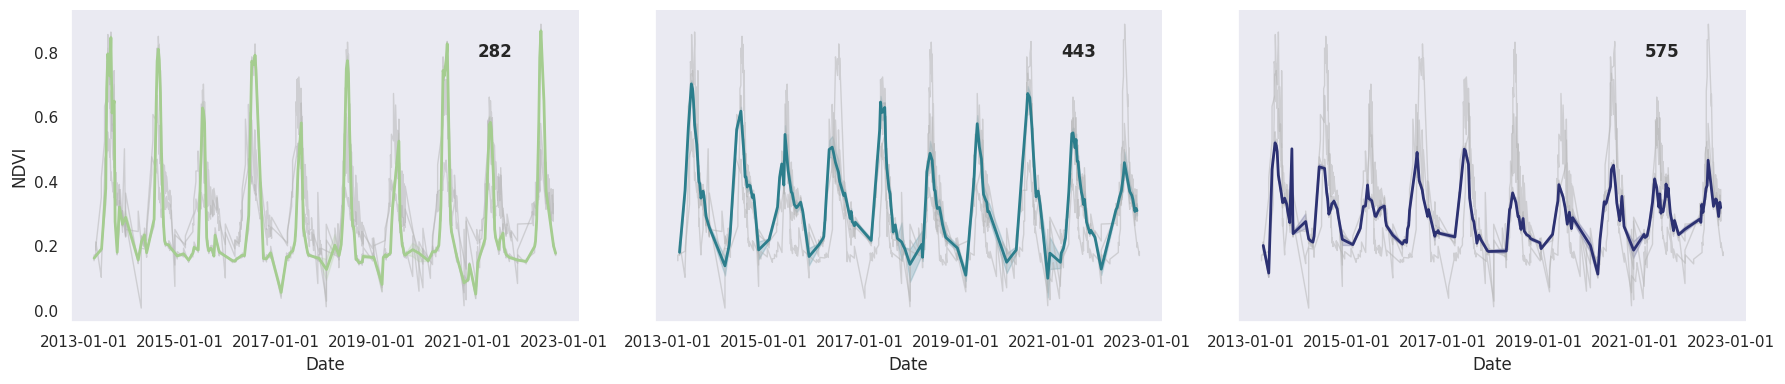

In [5]:
# Convert 'date' to datetime if not already done
lc08['date'] = pd.to_datetime(lc08['date'], unit='ms')

# Reduce sites:
sites = [282, 443, 575]
filtered_sites = lc08[lc08['site'].isin(sites)]

# Set the Seaborn theme
sns.set_theme(style="dark")

# Create the plot
g = sns.relplot(
    data=filtered_sites,
    x="date", y="ndvi", col="site", hue="site",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for site, ax in g.axes_dict.items():

    # Add the site as an annotation within the plot
    ax.text(.8, .85, site, transform=ax.transAxes, fontweight="bold")

    # Plot every site's NDVI time series in the background with low opacity
    sns.lineplot(
        data=filtered_sites, x="date", y="ndvi", units="site",
        estimator=None, color=".7", linewidth=1, ax=ax, alpha=0.5
    )

# Reduce the frequency of the x-axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Date", "NDVI")
g.tight_layout()

plt.show()

# LC09 reflectance


In [6]:
# Read the LC09 files into one dataframe
pickle_directory = 'data_out'
pickle_files = glob.glob(f"{pickle_directory}/time_series_LC09_batch_*.pkl")
dataframes = []
for pkl_file in pickle_files:
    with open(pkl_file, 'rb') as file:
        df = pickle.load(file)
        dataframes.append(df)

lc09 = pd.concat(dataframes, ignore_index = True)

In [7]:
# Check the columns
print(list(lc09.columns))

# Check # observatios per site
grouped_df = lc09.groupby("site").size()
print("Number of observatios per site: ")
print(grouped_df)

max(grouped_df)
min(grouped_df)

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'date', 'longitude', 'latitude', 'cosVZA', 'cosSZA', 'cosRAA', 'partition', 'site']
Number of observatios per site: 
site
282       187
443       192
575       185
607       167
678       181
         ... 
336784    115
337611    199
337661    134
344681    101
346867    195
Length: 1000, dtype: int64


30

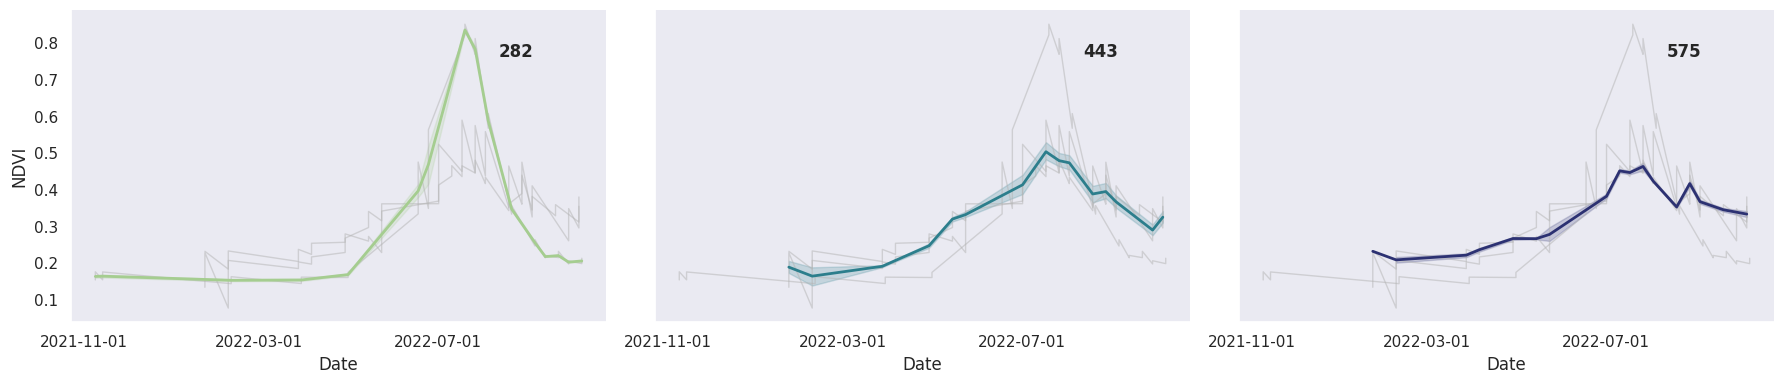

In [8]:
# Get ndvi
lc09 = calculate_ndvi(lc09, 'SR_B4', 'SR_B5')

# Convert 'date' to datetime
lc09['date'] = pd.to_datetime(lc09['date'], unit='ms')

# Reduce sites:
sites = [282, 443, 575]
filtered_sites = lc09[lc09['site'].isin(sites)]

# Set the Seaborn theme
sns.set_theme(style="dark")

# Create the plot
g = sns.relplot(
    data=filtered_sites,
    x="date", y="ndvi", col="site", hue="site",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for site, ax in g.axes_dict.items():
    
    # Add the site as an annotation within the plot
    ax.text(.8, .85, site, transform=ax.transAxes, fontweight="bold")

    # Plot every site's NDVI time series in the background with low opacity
    sns.lineplot(
        data=filtered_sites, x="date", y="ndvi", units="site",
        estimator=None, color=".7", linewidth=1, ax=ax, alpha=0.5
    )

# Reduce the frequency of the x-axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Date", "NDVI")
g.tight_layout()

plt.show()

# S2 reflectance


In [9]:
# import glob
# import pickle
# import pandas as pd
# import os

# Create pattern to match all S2 files
# pickle_directory = 'data_out/'
# pickle_pattern = os.path.join(
#     pickle_directory, "*temp*batch_S2_*_COPERNICUS_S2_SR_HARMONIZED_Surface_Reflectance_0_*_leaftoolbox.SL2PV0_*_*h_*mn*.pkl")

# # Get  matching pickle files
# pickle_files = glob.glob(pickle_pattern)

# dataframes = []

# for file in pickle_files:
#     with open(file, 'rb') as f:
#         # Load the pickle file
#         df = pickle.load(f)
#         outer_key = list(df.keys())[0]
#         first_item = df[outer_key]
#         batch_results = []
#         for item in range(len(first_item)):
#             df = first_item[item]['leaftoolbox.SL2PV0']
#             df['site'] = first_item[item]['feature']['wllst__']
#             batch_results.append(df)
#         # Append the DataFrame to the list
#         dataframes.append(df)

# # Concatenate all DataFrames into a single DataFrame
# combined_df = pd.concat(dataframes, ignore_index=True)

# Read file
file = 'data_out/sites_dictionary.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)

outer_key = list(df.keys())[0]
first_item = df[outer_key]
batch_results = []
for item in range(len(first_item)):
    df = first_item[item]['SL2PV0']
    df['site'] = first_item[item]['feature']['wllst__']
    batch_results.append(df)

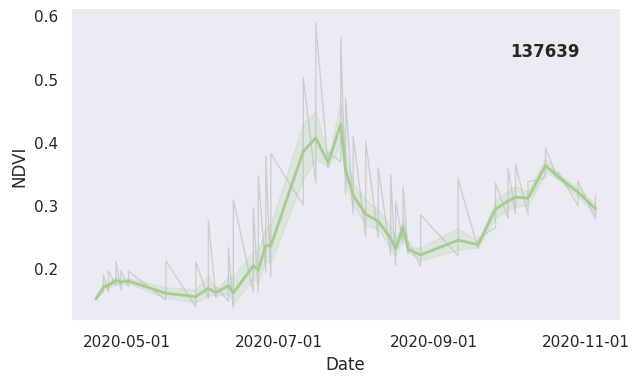

In [10]:
# Get ndvi
s2 = calculate_ndvi(df, 'B4', 'B8')

# Convert 'date' to datetime
s2['date'] = pd.to_datetime(s2['date'], unit='ms')

# Reduce sites:
sites = [137639]
filtered_sites = s2[s2['site'].isin(sites)]

# Set the Seaborn theme
sns.set_theme(style="dark")

# Create the plot
g = sns.relplot(
    data=filtered_sites,
    x="date", y="ndvi", col="site", hue="site",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for site, ax in g.axes_dict.items():

    # Add the site as an annotation within the plot
    ax.text(.8, .85, site, transform=ax.transAxes, fontweight="bold")

    # Plot every site's NDVI time series in the background with low opacity
    sns.lineplot(
        data=filtered_sites, x="date", y="ndvi", units="site",
        estimator=None, color=".7", linewidth=1, ax=ax, alpha=0.5
    )

# Reduce the frequency of the x-axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Date", "NDVI")
g.tight_layout()

plt.show()